In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA

from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.model_selection import train_test_split

# Create dataframe

In [3]:
ushapes = r"/content/drive/MyDrive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/UShape"
no_ushapes = r"/content/drive/MyDrive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/NoUshape"

In [4]:
def extract_spectrograms(path):
  os.chdir(path)
  spectrograms = []

  with os.scandir(path) as files:
    for file in files:
      if file.name.endswith('.png'):
        spectrograms.append(file.path)
  return spectrograms

ushapes_spectrograms = extract_spectrograms(ushapes)
all_spectrograms = extract_spectrograms(no_ushapes)

print(len(ushapes_spectrograms), len(all_spectrograms))
no_ushape_spectrograms = [spectrogram_without_ushape for spectrogram_without_ushape in all_spectrograms if spectrogram_without_ushape not in ushapes_spectrograms]

168 3822


In [5]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


dataframe_total = fill_df_with_label(ushapes_spectrograms, "ushape").append(fill_df_with_label(no_ushape_spectrograms, "noshape"))


df_train, df_rest = train_test_split(dataframe_total, random_state = 101, test_size=0.25)
df_val, df_eval = train_test_split(df_rest, random_state = 101, test_size=0.50)


In [6]:
print(df_val)

                                               filename    label
2292  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
2164  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1575  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1342  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1749  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
...                                                 ...      ...
605   /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
50    /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
646   /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
35    /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1869  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape

[499 rows x 2 columns]


In [7]:
# Initialize the Pretrained Model
feature_extractor = VGG16(include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(224, 224, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
print(df_val)

                                               filename    label
2292  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
2164  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1575  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1342  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1749  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
...                                                 ...      ...
605   /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
50    /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
646   /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
35    /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1869  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape

[499 rows x 2 columns]


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    # directory='harp/training/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    # directory='harp/validation/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 2992 validated image filenames belonging to 2 classes.
Found 499 validated image filenames belonging to 2 classes.


In [ ]:
pca = PCA(n_components=100, random_state=22)
x = pca.fit(train_generator)

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [11]:
history = model.fit(x, epochs=50, validation_data=val_generator)

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
94/94 [==============================] - 1330s 13s/step - loss: 0.3178 - accuracy: 0.9322 - val_loss: 0.2321 - val_accuracy: 0.9319
Epoch 2/50
13/94 [===>..........................] - ETA: 14:58 - loss: 0.1922 - accuracy: 0.9650

KeyboardInterrupt: ignored

In [ ]:
model.save('./harp_transfer_vgg16_more_50epochs')

In [ ]:
y_true = evaluation_ushape
y_pred = []
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

index = 1
for image_to_predict in evaluation_ushape:
    img = tf.keras.utils.load_img(
        ushapes + '/' + image_to_predict, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    ax = plt.subplot(10,10, index)
    ax.set_title(str(predictions[0]))
    plt.imshow(img)
    plt.axis('off')


    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1


1/1 [==============================] - 1s 531ms/step


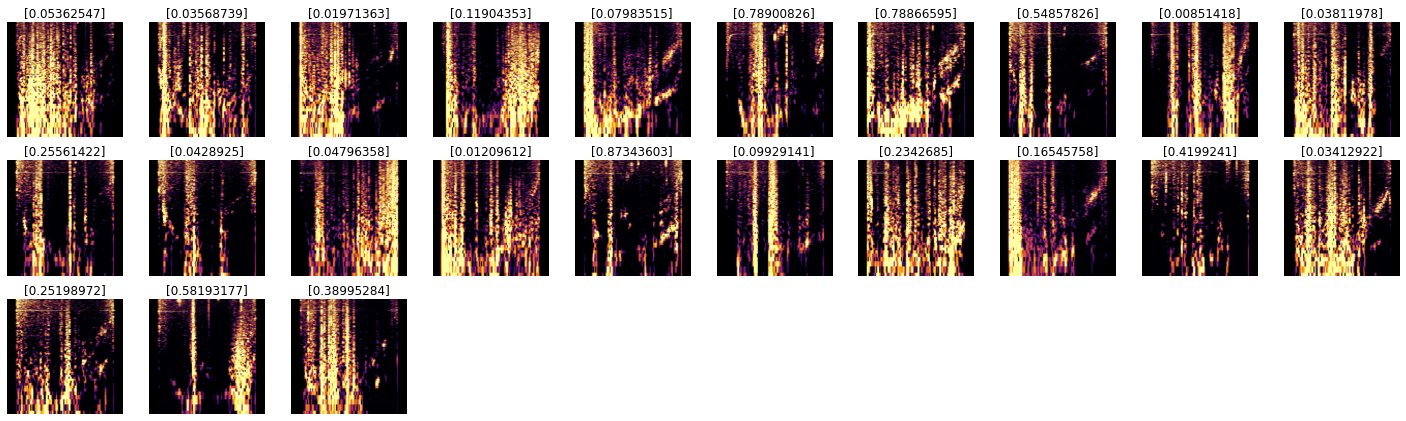

In [ ]:
y_true = evaluation_ushape
y_pred = []
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

index = 1
for image_to_predict in evaluation_no_ushape:
    img = tf.keras.utils.load_img(
        no_ushapes + '/' + image_to_predict, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    ax = plt.subplot(10,10, index)
    ax.set_title(str(predictions[0]))
    plt.imshow(img)
    plt.axis('off')


    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1


In [ ]:
def predcit_image(file_to_test):
  img = tf.keras.utils.load_img(
          file_to_test, target_size=(224, 224)
      )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)


  plt.axis('off')

  plt.imshow(img_array[0].numpy().astype("uint8"))

  print(predictions[0])



1/1 [==============================] - 1s 640ms/step
[0.27778342]


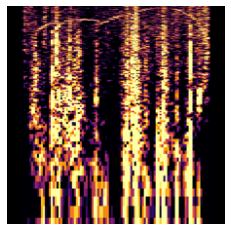

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20170206_20170207_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 1s 590ms/step
[0.8370462]


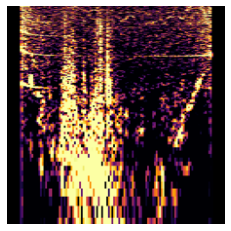

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20170524_20170525_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 1s 546ms/step
[7.1710353e-09]


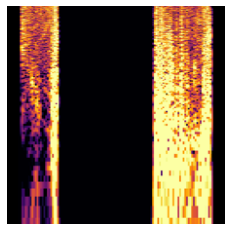

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20170615_20170617_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 1s 551ms/step
[7.1710353e-09]


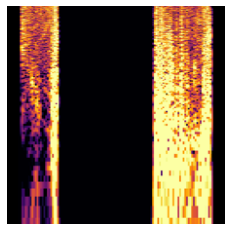

In [ ]:

file_to_test = no_ushapes + "/THE_stft_20170615_20170617_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 1s 559ms/step
[0.69677734]


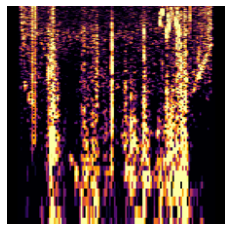

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20190203_20190204_dynamic.png"
predcit_image(file_to_test)

In [ ]:
print(model.history.history)

{}


In [ ]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


dataframe_total = fill_df_with_label(ushapes_spectrograms, "ushape").append(fill_df_with_label(no_ushape_spectrograms, "noshape"))


df_train, df_val = train_test_split(dataframe_total, random_state = 101, test_size=0.25)acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(
    , train_images_y_encoded, random_state = 101, 
                                                   test_size=0.25)


n_folds=3
epochs=50
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_generator, train_y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

SyntaxError: ignored